# Atom-inpainting example

This example walks through the procedure for atom-inpainting with ShEPhERD.

Note that this uses the auxiliary `shepherd-score` package for convenience. If you want to only use the packages in this repo, please reference `RUNME_conditional_generation_MOSESaq.ipynb`.

In [ ]:
import os
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from copy import deepcopy

import torch

from shepherd import load_model
from shepherd.inference.sampler import generate, generate_from_intermediate_time
from shepherd.extract import remove_overlaps
from shepherd_score.evaluations.evaluate import ConditionalEval
from shepherd_score.visualize import draw_2d_highlight, draw_sample

from shepherd_score.visualize import draw, draw_molecule, draw_2d_valid
from shepherd_score.container import Molecule
from shepherd_score.conformer_generation import charges_from_single_point_conformer_with_xtb
from shepherd_score.conformer_generation import update_mol_coordinates

tmp_dir = os.environ.get('TMPDIR', './')

def clean_samples_of_overlaps(conditional_samples, inpainted_atom_positions, cutoff=0.5, verbose=True):
    """ Helper function to remove overlaps from all generated samples. """
    _conditional_samples = deepcopy(conditional_samples)
    for i, _cs in enumerate(_conditional_samples):
        _conditional_samples[i] = remove_overlaps(_cs, inpainted_atom_positions, cutoff, verbose)
    return _conditional_samples


def evaluate_conditional_samples(conditional_samples, molec):
    """
    Simple function that runs our evaluation suite on all of the samples.
    Use `shepherd_score`'s `ConditionalEval` class to evaluate each sample.
    It evaulates 1) the validity of the sampled molecule, 2) evaluates the
    quality of the conformer 3) measures the interaction profile similarity
    to the target molecule.

    Using this instead of ConditionalEvalPipeline for simplicity.

    Args
    ----
    conditional_samples : outputted samples
    molec : target molecule

    Returns
    -------
    cond_evals : list of `shepherd_score` `ConditionalEval` objects
    """
    num_valid = []
    num_valid_post_opt = []
    cond_evals = []
    for sample in tqdm(conditional_samples, leave=True):
        # run the evaluation
        cond_eval = ConditionalEval(atoms=sample['x1']['atoms'],
                                    positions=sample['x1']['positions'],
                                    condition='pharm', solvent='water',
                                    ref_molec=molec,
                                    num_surf_points=400,
                                    pharm_multi_vector=False)
        # store them so we can access them later
        cond_evals.append(cond_eval)
        num_valid.append(cond_evals[-1].is_valid)
        num_valid_post_opt.append(cond_evals[-1].is_valid_post_opt)

    # summary table of valid structures
    msg = f'\nSample  |  Valid  |  Valid Post-opt'
    print(msg)
    print('-'*len(msg))
    for i in range(len(cond_evals)):
        print(f'    {i}   |  {cond_evals[i].is_valid}   |   {cond_evals[i].is_valid_post_opt}  ')
    return cond_evals

### Load ShEPhERD
This will download the model weights if this is the first time using it.

In [ ]:
model_pl = load_model('mosesaq', device='cuda')
solvent = 'water' # this should be None for any of the GDB models

### Set-up your reference molecule
You should obtain a conformer that you would like to condition ShEPHERD on. For the sake of example, we will use the PDB ligand WX7 that we've separately extracted the bound pose.

Next, we need to center the molecule. This is important otherwise ShEPhERD may fail.

In [3]:
mol = Chem.SupplierFromFilename('./data/WX7.sdf', removeHs=False)[0]
center_of_mass = mol.GetConformer().GetPositions().mean(0)
centered_mol = update_mol_coordinates(mol, mol.GetConformer().GetPositions() - center_of_mass)
orig_partial_charges = charges_from_single_point_conformer_with_xtb(centered_mol, solvent=solvent, temp_dir=tmp_dir)
molec = Molecule(
    centered_mol,
    num_surf_points=75, # required for shepherd
    probe_radius=0.6, # required for shepherd
    partial_charges = orig_partial_charges,
    pharm_multi_vector=False  # required for shepherd
)

#### Select the atoms that we want to inpaint
We include a visualization tool to highlight what will be inpainted.

We can also optinally include a set of "exit vector" atom indices. By specifying these, all edges (e.g., bonds) between inpainted atoms will be inpainted in addition to `None` edge-types between non-bonded atoms *except* for "exit vector" atoms which will only diffuse bond-types between connected inpainted atoms.

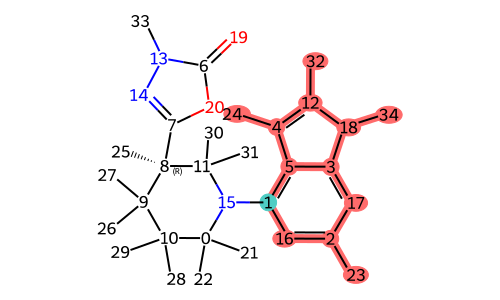

In [4]:
atom_inds_to_inpaint = [1, 16, 2, 23, 17, 3, 5, 4, 24, 12, 18, 34, 32]
exit_vector_atom_inds = [1]
draw_2d_highlight(mol, [atom_inds_to_inpaint, exit_vector_atom_inds], label='atomLabel', width=500, height=300)

### (optional) Downselect pharmacophores

Sometimes you might be interested in only a set number of pharmacophores. Here is a cell that can help you figure out what pharmacophores to remove

In [5]:
print(molec.pharm_types)
pharm_to_remove = [1, 5, 11, 3]
pharm_to_keep = np.array([True if i not in pharm_to_remove else False for i in range(len(molec.pharm_types))])
molec_new = deepcopy(molec)
molec_new.pharm_types = molec.pharm_types[pharm_to_keep]
molec_new.pharm_ancs = molec.pharm_ancs[pharm_to_keep]
molec_new.pharm_vecs = molec.pharm_vecs[pharm_to_keep]
draw_molecule(molec_new)

[2 2 2 1 1 0 0 0 0 3 3 3 3]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Generate samples with ShEPhERD

This set of inputs will condition ShEPhERD on the specified atoms, surface, ESP, and downselected pharmacophores.

Typically you'd want to scan over `N_x1` and `N_x4`.

In [6]:
batch_size = 10

generated_samples = generate(
    model_pl=model_pl,
    batch_size=batch_size,
    N_x1 = molec_new.mol.GetNumAtoms(),
    N_x4 = len(molec_new.pharm_types) + 2, # Add in a couple to compensate for the removed pharmacophores
    unconditional=False,
    #####################
    # Atom inpainting specific arguments
    inpaint_x1_pos = True,
    inpaint_x1_x = True,
    inpaint_x1_bonds = True,
    #####################
    inpaint_x3_pos = True,
    inpaint_x3_x = True,
    inpaint_x4_pos = True,
    inpaint_x4_direction = True,
    inpaint_x4_type = True,

    # these are the inpainting targets
    center_of_mass = np.zeros(3),
    #####################
    # Atom inpainting specific arguments
    atom_inds_to_inpaint = atom_inds_to_inpaint,
    mol = molec.mol, # supply the original molecule
    exit_vector_atom_inds=exit_vector_atom_inds, # optional
    #####################
    surface = molec_new.surf_pos,
    electrostatics = molec_new.surf_esp,
    pharm_types = molec_new.pharm_types,
    pharm_pos = molec_new.pharm_ancs,
    pharm_direction = molec_new.pharm_vecs,
    verbose=True,

    num_steps=400
)
torch.cuda.empty_cache() # clear GPU memory

100%|█████████████████████████████████████████| 399/399 [01:19<00:00,  5.04it/s]


### Clean the generated samples from overlaps and evaluate

Atom-inpainting can have a higher propensity for sampling atoms on top of the inpainted atoms. We use a helper function to remove these overlaps using a simple check for whether there are any freely diffused atoms within 0.75A of the inpainted-atoms.


We use the evaluation helper function instead of ConditionalEvalPipeline just for simplicity of this notebook.

In [7]:
generated_samples_no_overlaps = clean_samples_of_overlaps(
    generated_samples,
    inpainted_atom_positions=molec_new.mol.GetConformer().GetPositions()[np.array(atom_inds_to_inpaint)],
    cutoff=0.75,
    verbose=False
)

cond_evals = evaluate_conditional_samples(generated_samples_no_overlaps, molec_new)

100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


Sample  |  Valid  |  Valid Post-opt
------------------------------------
    0   |  True   |   True  
    1   |  True   |   True  
    2   |  True   |   True  
    3   |  True   |   True  
    4   |  True   |   True  
    5   |  True   |   True  
    6   |  True   |   True  
    7   |  True   |   True  
    8   |  True   |   True  
    9   |  True   |   True  


### Visualize the 2D graphs of the sampled molecules

This function can sometimes fail.

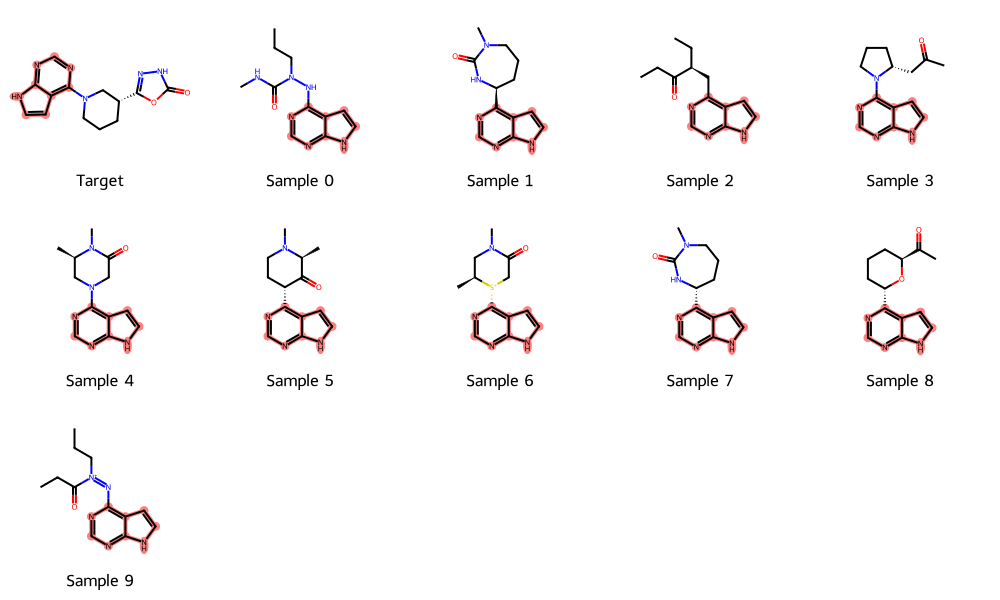

In [8]:
# Visualize the valid molecules as 2D graphs
draw_2d_valid(mol, [m.mol_post_opt for m in cond_evals])

### Visualize the molecules in 3D

We are viewing three conformers here.
1. Reference molecule (translucent)
2. Sampled molecule (e.g., without relaxation) with white carbons
3. Molecule post-xTB optimization and re-aligned to the inpainted substructure with grey carbons

In [9]:
ind_to_view=0
copied_mol = deepcopy(cond_evals[ind_to_view].molec_post_opt.mol)
rmsd = Chem.rdMolAlign.AlignMol(copied_mol, deepcopy(molec_new.mol),
                        atomMap=[(j, i) for j, i in enumerate(atom_inds_to_inpaint)])
print(f'RMSD: {rmsd}')
view = draw(molec_new.mol, opacity=0.6)
# view = draw_molecule(molec, opacity=0.6, opacity_features=0.6, color_scheme='whiteCarbon', no_surface_points=True)
view = draw_sample(generated_samples[ind_to_view], view=view, only_atoms=True, color_scheme='whiteCarbon')
view = draw(copied_mol, view=view)
view.show()

RMSD: 0.05580424479056644


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Inpainting from an intermediate time
Rather than inpainting from t=T, it might be desireable to find structurally local molecules and sample molecules from an intermediate time-step.

This gives us a couple new options relevant to this.
- `start_time`: float (where 0 is the data distribution). Typically something <0.4 is desired.
- `new_atom_placement_region`: np.array | None
    - Rather than having the freely diffused atoms centered around the origin, you can place it whereever you like.
- `new_atom_placement_radius`: float Radius in angstroms
- `new_atom_types`: list[str] The atom types of the freely diffused atoms to forward noise to have a more realistic intermediate distribution
- `new_atom_type_weights`: list[float] probability of choosing the atom types for the freely diffused atoms

In [10]:
batch_size = 10
out = generate_from_intermediate_time(
    model_pl=model_pl,
    batch_size=10,
    N_x1 = molec_new.mol.GetNumAtoms() + 4, # Can change this to add more atoms
    N_x4 = len(molec_new.pharm_types) + 2, # Can change this to add more pharmacophores
    ##################################################
    ############## New inpainting args ###############
    ##################################################
    start_time = 0.4,
    ##### these are the inpainting targets
    center_of_mass = np.zeros(3),
    mol=molec_new.mol,
    atom_inds_to_inpaint = atom_inds_to_inpaint,
    ##### where to add the new atoms
    # for this example, we place the atoms around the 25th atom which is far from the scaffold
    new_atom_placement_region = molec.mol.GetConformer().GetPositions()[25],
    new_atom_placement_radius = 0.5,
    ##### probability distribution of atom types
    new_atom_types = ['C', 'O', 'N', 'F', 'H'],
    new_atom_type_weights = [0.3, 0.2, 0.2, 0.1, 0.2],
    ##### Bonds #####
    inpaint_x1_bonds=True,
    exit_vector_atom_inds=exit_vector_atom_inds,
    ##################################################

    surface = molec_new.surf_pos,
    electrostatics = molec_new.surf_esp,
    pharm_types = molec_new.pharm_types,
    pharm_pos = molec_new.pharm_ancs,
    pharm_direction = molec_new.pharm_vecs,

    verbose=True,
)

100%|█████████████████████████████████████████| 159/159 [00:29<00:00,  5.34it/s]


In [12]:
generated_samples_no_overlaps_intermediate = clean_samples_of_overlaps(out,
                                                          molec_new.mol.GetConformer().GetPositions()[np.array(atom_inds_to_inpaint)],
                                                         cutoff=0.7, verbose=False)
cond_evals_intermediate = evaluate_conditional_samples(generated_samples_no_overlaps_intermediate, molec_new)

100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.67s/it]


Sample  |  Valid  |  Valid Post-opt
------------------------------------
    0   |  True   |   True  
    1   |  False   |   False  
    2   |  False   |   True  
    3   |  False   |   False  
    4   |  True   |   True  
    5   |  False   |   False  
    6   |  True   |   True  
    7   |  True   |   True  
    8   |  False   |   False  
    9   |  False   |   False  


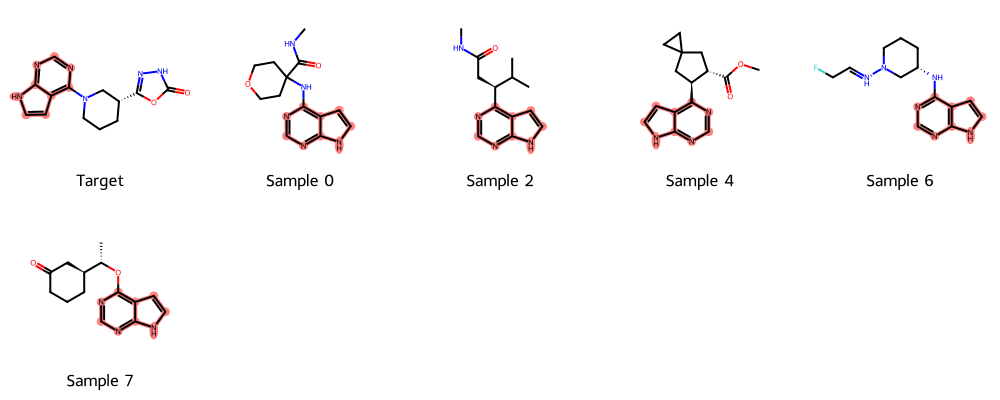

In [13]:
draw_2d_valid(mol, [ce.mol_post_opt for ce in cond_evals_intermediate])

In [15]:
ind_to_view=0
copied_mol = deepcopy(cond_evals_intermediate[ind_to_view].molec_post_opt.mol)
rmsd = Chem.rdMolAlign.AlignMol(copied_mol, deepcopy(molec_new.mol),
                        atomMap=[(j, i) for j, i in enumerate(atom_inds_to_inpaint)])
print(f'RMSD: {rmsd}')
view = draw(molec_new.mol, opacity=0.6)
# view = draw_molecule(molec, opacity=0.6, opacity_features=0.6, color_scheme='whiteCarbon', no_surface_points=True)
view = draw(copied_mol, view=view)
view.show()

RMSD: 0.05455872728022353


3Dmol.js failed to load for some reason. Please check your browser console for error messages.